In [1]:
import GPR
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from IPython.display import Image
pd.options.display.max_columns = 50
#pd.options.display.max_rows = None

In [2]:
def plot_result(result, figsize=(10,10), shift_stats_pos=(1,5), limits=[0, 13],
                ax=None, c="black", marker=".", show_stats=True):
    import scipy
    from matplotlib import pyplot as plt
    from sklearn import metrics

    fig = plt.figure()
    fig.set_figheight(figsize[0]);fig.set_figwidth(figsize[1])
    if ax==None:
        ax = plt.subplot(1,1,1)
        limit = np.array(limits)
        x,y = list(result["Exp."]),list(result["Prediction"])
        ax.plot(limit, limit, color="k")
        ax.fill_between(limit, limit+1.0, limit-1.0, facecolor='brown', alpha=0.35)
        ax.fill_between(limit, limit+2.0, limit-2.0, facecolor='wheat', alpha=0.50)
        ax.set_xlabel("Exp", size=16)
        ax.set_ylabel("Predicted", size=16)
        ax.set_xlim(limit)
        ax.set_ylim(limit)

        # Setting the ticks and tick marks
        ticks = [ax.xaxis.get_minor_ticks(),
                 ax.xaxis.get_major_ticks()]
        marks = [ax.get_xticklabels(),
                ax.get_yticklabels()]
        for k in range(0,len(ticks)):
            for tick in ticks[k]:
                tick.label.set_fontsize(16)
        for k in range(0,len(marks)):
            for mark in marks[k]:
                mark.set_size(fontsize=16)
                mark.set_rotation(s=15)

    x,y = list(result["Exp."]),list(result["Prediction"])
    ax.scatter(x, y, s=15, c=c, marker=marker)
    ax.errorbar(x, y, yerr=list(result["Prediction Std"]), fmt=marker,
            color=c, ecolor=c, capthick=1, capsize=2)

    if show_stats==True:
        R2 = np.corrcoef(x, y)[0][1]**2
        MAE = metrics.mean_absolute_error(x, y)
        MSE = metrics.mean_squared_error(x, y)
        RMSE = np.sqrt(metrics.mean_squared_error(x, y))

        posx,posy = np.min(x)+shift_stats_pos[0], np.max(y)+shift_stats_pos[1]
        string = r'''
        $R^{2}$ = %0.3f
        $MAE$ = %0.3f
        $MSE$ = %0.3f
        $RMSE$ = %0.3f'''%(R2, MAE, MSE, RMSE)
        ax.annotate(string, xy=(posx,posy), xytext=(posx,posy), size=16, color=c)

    fig = ax.get_figure()
    fig.tight_layout()
    return ax

def macro_minimum_difference(exp, predictions, verbose=False):
    """Very ugly code that matches pKa predictions with experiemntal values
    using the principle of smallest difference.
    
    Args:
       exp(pd.DataFrame) - experiment from csv file
       predictions(pd.DataFrame) - predictions from results
    """

    predictions = predictions.to_numpy()
    keys = [key for key in exp.keys() if ("Exp." in key) and ("SEM" not in key)]
    nMacro = len(keys)
    exp_array = exp[keys].to_numpy()
    macro,macro_std = [],[]
    for i,SM in enumerate(list(exp["Molecule ID"])):
        pred = [float(str(j).split("+/-")[0]) for j in predictions[i]]
        # find the pka values that has the smallest difference
        if all(np.isnan(pred)): print(SM);continue
        for k,pka in enumerate(exp_array[i]):
            if np.isnan(pka): continue
            if verbose: print(type(pka),pka)
            if verbose: print(type(predictions[i]),predictions[i])
            index = np.where(np.abs(pka - pred) == np.nanmin(np.abs(pka - pred)))[0][0]
            if verbose: print(index)
            val_str = str(predictions[i][int(index)])
            m,m_std = val_str.split("+/-")
            macro.append({"SM": SM, f"{k}": float(m), f"{k} std": float(m_std)})
    macro_predictions = pd.DataFrame(macro)
    mp = macro_predictions.groupby("SM").agg("mean")

    e1 = pd.concat([exp.iloc[:,0], exp.iloc[:,1:3]], axis=1)
    e1.columns = ["Molecule ID", "Exp.", "Exp. SEM"]
    Exp = e1
    # NOTE: depends on the number of macroscopic pKas
    if nMacro > 1:
        e2 = pd.concat([exp.iloc[:,0], exp.iloc[:,3:5]], axis=1)
        e2.columns = ["Molecule ID", "Exp.", "Exp. SEM"]
        Exp = pd.concat([e1,e2], axis=0)

    p1 = mp.iloc[:,0:2].reset_index()
    p1.columns = ["Molecule ID", "Prediction", "Prediction Std"]
    Pred = p1.dropna()
    # NOTE: depends on the number of macroscopic pKas
    if nMacro > 1:
        p2 = mp.iloc[:,2:].reset_index()
        p2.columns = ["Molecule ID", "Prediction", "Prediction Std"]
        Pred = pd.concat([p1,p2], axis=0)

    # NOTE: Find SMs that are not in the predictions dataframe
    experiment,experiment_std = [],[]
    k = 0
    for i in range(len(list(Exp["Molecule ID"]))):
        SM_e = Exp["Molecule ID"].iloc[[i]].to_numpy()[0]
        SM_p = Pred["Molecule ID"].iloc[[k]].to_numpy()[0]
        if SM_e == SM_p:
            experiment.append(Exp["Exp."].iloc[[i]].to_numpy()[0])
            experiment_std.append(Exp["Exp. SEM"].iloc[[i]].to_numpy()[0])
            k += 1
    result = Pred
    result["Exp."] = experiment
    result["Exp. Std"] = experiment_std
    return result

def macro_to_latex_table(df, filename="table.tex"):
    df = df.replace(np.nan, '', regex=True)
    df['Prediction'] = df['Prediction'].apply(str)
    df['Prediction Std'] = df['Prediction Std'].apply(str)
    df['Exp.'] = df['Exp.'].apply(str)
    df['Exp. Std'] = df['Exp. Std'].apply(str)
    df['Prediction'] = "$"+df['Prediction']+"\pm"+df['Prediction Std']+"$"
    df['Experiment'] = "$"+df['Exp.']+"\pm"+df['Exp. Std']+"$"
    df = df.set_index('Molecule ID').sort_values('Molecule ID')
    df = df.drop(['Prediction Std', 'Exp.', 'Exp. Std'], axis=1)
    df.to_latex(filename, longtable=True, index=True)
    return df

def free_energies_to_publication_format(df):
    df = df.round(2)
    df['Ref'] = [x.replace("_micro"," m") for x in df['Ref'].to_numpy()]
    df['Microstate ID'] = [x.replace("_micro"," m") for x in df['Microstate ID'].to_numpy()]
    df['∆G'] = df['∆G'].apply(str)
    df['∆G std'] = df['∆G std'].apply(str)
    df['prediction'] = "$"+df['∆G']+"\pm"+df['∆G std']+"$"
    df = df.drop(['∆G', '∆G std'], axis=1)
    return df

## Macroscipic $pK_{a}$ Results for SAMPL6

SM03
SM05
SM10
SM18
SM19
SM23
SM03
SM05
SM10
SM18
SM19
SM23


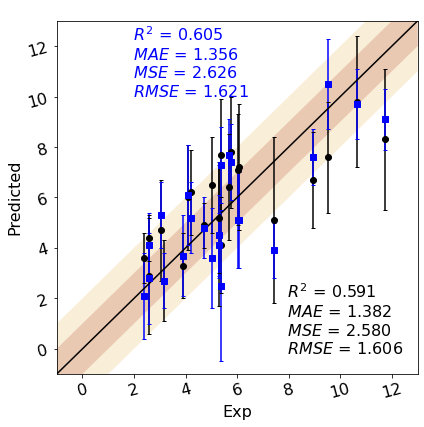

<Figure size 432x432 with 0 Axes>

In [3]:
# NOTE: SAMPL6
expS6 = pd.read_csv("../Structures/SAMPL6/SAMPL6_experimental_pkas.csv", index_col=False)
stdGP6 = pd.read_csv("../predictions/SAMPL6_stdGP/macropKa_predictions.csv", index_col=False)
deepGP6 = pd.read_csv("../predictions/SAMPL6_deepGP/macropKa_predictions.csv", index_col=False)

expS6 = expS6.drop(columns=["canonical isomeric SMILES", "Assay Type", "Experimental Molecule ID"])
expS6.columns = ["Molecule ID","Exp.1", "Exp.1 SEM","Exp.2", "Exp.2 SEM","Exp.3", "Exp.3 SEM"]

# NOTE:  Standard GP
df6 = macro_minimum_difference(exp=expS6, predictions=stdGP6)
df6 = df6.dropna(subset=["Prediction", "Prediction Std", "Exp.","Exp. Std"], thresh=3)
ax = plot_result(df6, figsize=(6,6), shift_stats_pos=(4,-10.0), limits=[-1,13],
            ax=None, c="black", marker="o", show_stats=True)

# NOTE:  deep GP
df6 = macro_minimum_difference(exp=expS6, predictions=deepGP6)
df6 = df6.dropna(subset=["Prediction", "Prediction Std", "Exp.","Exp. Std"], thresh=3)
plot_result(df6, figsize=(6,6), shift_stats_pos=(-2,-0.5), limits=[-1,13],
                ax=ax, c="blue", marker="s", show_stats=True)
fig = ax.get_figure()
fig.savefig("../figures/SAMPL6_results.pdf", dpi=300)

In [4]:
df = macro_minimum_difference(exp=expS6, predictions=stdGP6)
macro_to_latex_table(df, filename="../tables/stdGP_SAMPL6_macro_pkas.tex")

SM03
SM05
SM10
SM18
SM19
SM23


,Prediction,Experiment
Molecule ID,,
SM01,$7.6\pm2.2$,$9.53\pm0.01$
SM01,$\pm$,$\pm$
SM02,$6.5\pm1.9$,$5.03\pm0.01$
SM02,$\pm$,$\pm$
SM04,$7.1\pm2.2$,$6.02\pm0.01$
...,...,...
SM21,$6.0\pm2.1$,$4.1\pm0.01$
SM22,$5.1\pm3.3$,$7.43\pm0.01$
SM22,$3.6\pm1.0$,$2.4\pm0.02$


In [5]:
df = macro_minimum_difference(exp=expS6, predictions=deepGP6)
macro_to_latex_table(df, filename="../tables/deepGP_SAMPL6_macro_pkas.tex")

SM03
SM05
SM10
SM18
SM19
SM23


,Prediction,Experiment
Molecule ID,,
SM01,$10.5\pm1.8$,$9.53\pm0.01$
SM01,$\pm$,$\pm$
SM02,$3.6\pm2.0$,$5.03\pm0.01$
SM02,$\pm$,$\pm$
SM04,$5.1\pm1.9$,$6.02\pm0.01$
...,...,...
SM21,$6.1\pm2.0$,$4.1\pm0.01$
SM22,$3.9\pm1.1$,$7.43\pm0.01$
SM22,$2.1\pm1.7$,$2.4\pm0.02$


## Macroscipic $pK_{a}$ Results for SAMPL7

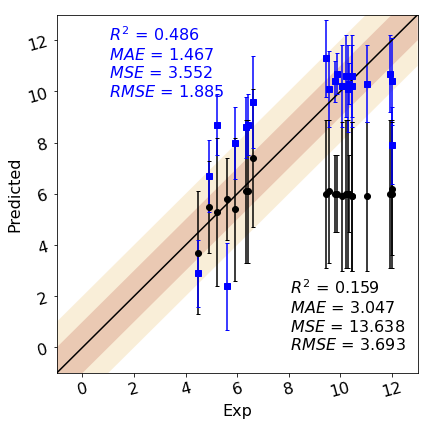

<Figure size 432x432 with 0 Axes>

In [6]:
# NOTE: SAMPL7
expS7 = pd.read_csv("../Structures/SAMPL7/SAMPL7_pKa_experimental_values.csv", index_col=False)
stdGP7 = pd.read_csv("../predictions/SAMPL7_stdGP/macropKa_predictions.csv", index_col=False)
deepGP7 = pd.read_csv("../predictions/SAMPL7_deepGP/macropKa_predictions.csv", index_col=False)

expS7 = expS7.drop(columns=["Isomeric SMILES", "Assay Type"])
expS7.columns = ["Molecule ID","Exp.", "Exp. SEM"]

# NOTE:  Standard GP
df7 = macro_minimum_difference(exp=expS7, predictions=stdGP7)
ax = plot_result(df7, figsize=(6,6), shift_stats_pos=(2,-7.5), limits=[-1,13],
            ax=None, c="black", marker="o", show_stats=True)

# NOTE:  deep GP
df7 = macro_minimum_difference(exp=expS7, predictions=deepGP7)
plot_result(df7, figsize=(6,6), shift_stats_pos=(-5,-1.5), limits=[-1,13],
                ax=ax, c="blue", marker="s", show_stats=True)
fig = ax.get_figure()
fig.savefig("../figures/SAMPL7_results.pdf", dpi=300)

In [7]:
df = macro_minimum_difference(exp=expS7, predictions=stdGP7)
macro_to_latex_table(df, filename="../tables/stdGP_SAMPL7_macro_pkas.tex")

,Prediction,Experiment
Molecule ID,,
SM25,$3.7\pm2.4$,$4.49\pm0.04$
SM26,$5.5\pm1.8$,$4.91\pm0.01$
SM27,$5.9\pm2.9$,$10.45\pm0.01$
SM28,$6.2\pm2.6$,$12.0\pm$
SM29,$5.9\pm2.9$,$10.05\pm0.01$
...,...,...
SM42,$7.4\pm2.7$,$6.62\pm0.02$
SM43,$5.8\pm1.6$,$5.62\pm0.02$
SM44,$6.1\pm2.8$,$6.34\pm0.01$


In [8]:
df = macro_minimum_difference(exp=expS7, predictions=deepGP7)
macro_to_latex_table(df, filename="../tables/deepGP_SAMPL7_macro_pkas.tex")

,Prediction,Experiment
Molecule ID,,
SM25,$2.9\pm1.3$,$4.49\pm0.04$
SM26,$6.7\pm1.4$,$4.91\pm0.01$
SM27,$10.2\pm1.6$,$10.45\pm0.01$
SM28,$7.9\pm1.5$,$12.0\pm$
SM29,$10.2\pm1.6$,$10.05\pm0.01$
...,...,...
SM42,$9.6\pm1.8$,$6.62\pm0.02$
SM43,$2.4\pm1.7$,$5.62\pm0.02$
SM44,$8.6\pm1.2$,$6.34\pm0.01$


## Relative Free Energies for SAMPL6


In [9]:
stdGP6 = pd.read_csv("../predictions/SAMPL6_stdGP/free_energy_predictions.csv", index_col=False)
deepGP6 = pd.read_csv("../predictions/SAMPL6_deepGP/free_energy_predictions.csv", index_col=False)

In [10]:
stdGP6 = free_energies_to_publication_format(stdGP6)
stdGP6

,Ref,Microstate ID,Charge,prediction
0,SM01 m001,SM01 m005,0,$10.31\pm4.06$
1,SM01 m001,SM01 m006,0,$7.95\pm4.37$
2,SM02 m002,SM02 m011,-1,$8.23\pm4.44$
3,SM02 m002,SM02 m004,1,$-5.97\pm3.23$
4,SM02 m002,SM02 m005,1,$-6.88\pm1.35$
...,...,...,...,...
54,SM22 m001,SM22 m004,-1,$6.88\pm4.43$
55,SM22 m001,SM22 m002,1,$-4.92\pm1.34$
56,SM24 m001,SM24 m007,0,$7.58\pm3.34$
57,SM24 m001,SM24 m028,0,$4.63\pm3.29$


In [11]:
deepGP6 = free_energies_to_publication_format(deepGP6)
deepGP6

,Ref,Microstate ID,Charge,prediction
0,SM01 m001,SM01 m005,0,$8.28\pm1.75$
1,SM01 m001,SM01 m006,0,$7.61\pm1.86$
2,SM02 m002,SM02 m011,-1,$11.14\pm4.12$
3,SM02 m002,SM02 m004,1,$-2.2\pm2.3$
4,SM02 m002,SM02 m005,1,$-7.16\pm2.53$
...,...,...,...,...
54,SM22 m001,SM22 m004,-1,$5.03\pm2.36$
55,SM22 m001,SM22 m002,1,$-2.8\pm2.26$
56,SM24 m001,SM24 m007,0,$7.09\pm2.24$
57,SM24 m001,SM24 m028,0,$6.33\pm2.58$


## Relative Free Energies for SAMPL7

In [12]:
stdGP7 = pd.read_csv("../predictions/SAMPL7_stdGP/free_energy_predictions.csv", index_col=False)
deepGP7 = pd.read_csv("../predictions/SAMPL7_deepGP/free_energy_predictions.csv", index_col=False)

In [13]:
stdGP7 = free_energies_to_publication_format(stdGP7)
stdGP7

,Ref,Microstate ID,Charge,prediction
0,SM25 m000,SM25 m001,-1,$16.48\pm7.83$
1,SM25 m000,SM25 m003,-1,$8.28\pm3.94$
2,SM25 m000,SM25 m005,1,$0.17\pm5.53$
3,SM25 m000,SM25 m002,0,$8.06\pm3.95$
4,SM26 m000,SM26 m001,-1,$7.8\pm2.69$
...,...,...,...,...
48,SM45 m000,SM45 m002,1,$-7.41\pm3.79$
49,SM46 m000,SM46 m001,-1,$8.27\pm3.87$
50,SM46 m000,SM46 m002,1,$-7.37\pm3.59$
51,SM46 m000,SM46 m004,1,$-7.81\pm3.89$


In [14]:
deepGP7 = free_energies_to_publication_format(deepGP7)
deepGP7

,Ref,Microstate ID,Charge,prediction
0,SM25 m000,SM25 m001,-1,$24.48\pm3.47$
1,SM25 m000,SM25 m003,-1,$12.28\pm1.98$
2,SM25 m000,SM25 m005,1,$-3.3\pm5.76$
3,SM25 m000,SM25 m002,0,$7.79\pm4.85$
4,SM26 m000,SM26 m001,-1,$6.0\pm1.79$
...,...,...,...,...
48,SM45 m000,SM45 m002,1,$-3.42\pm2.24$
49,SM46 m000,SM46 m001,-1,$11.82\pm1.64$
50,SM46 m000,SM46 m002,1,$-2.35\pm2.25$
51,SM46 m000,SM46 m004,1,$-13.11\pm2.14$


In [15]:
stdGP6.to_latex("../tables/stdGP_SAMPL6_free_energies.tex", longtable=True, index=False)
deepGP6.to_latex("../tables/deepGP_SAMPL6_free_energies.tex", longtable=True, index=False)
stdGP7.to_latex("../tables/stdGP_SAMPL7_free_energies.tex", longtable=True, index=False)
deepGP7.to_latex("../tables/deepGP_SAMPL7_free_energies.tex", longtable=True, index=False)

## Macroscipic $pK_{a}$ Results for Random Forest Model in SAMPL6  w/ and w/out similatiry filter
## Relative Free Energies for Random Forest Model in SAMPL6

SM03
SM05
SM10
SM18
SM19
SM23
SM03
SM05
SM10
SM18
SM19
SM23


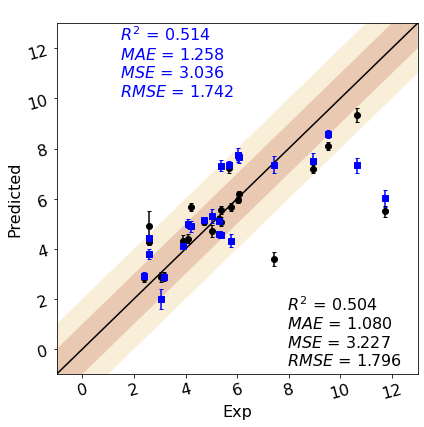

<Figure size 432x432 with 0 Axes>

In [3]:
# NOTE: SAMPL6
expS6 = pd.read_csv("../Structures/SAMPL6/SAMPL6_experimental_pkas.csv", index_col=False)
stdGP6 = pd.read_csv("../predictions/RandomForestSAMPL6_without_filter/macropKa_predictions.csv", index_col=False)
deepGP6 = pd.read_csv("../predictions/RandomForestSAMPL6/macropKa_predictions.csv", index_col=False)

expS6 = expS6.drop(columns=["canonical isomeric SMILES", "Assay Type", "Experimental Molecule ID"])
expS6.columns = ["Molecule ID","Exp.1", "Exp.1 SEM","Exp.2", "Exp.2 SEM","Exp.3", "Exp.3 SEM"]

# NOTE:  Standard GP
df6 = macro_minimum_difference(exp=expS6, predictions=stdGP6)
df6 = df6.dropna(subset=["Prediction", "Prediction Std", "Exp.","Exp. Std"], thresh=3)
ax = plot_result(df6, figsize=(6,6), shift_stats_pos=(4,-10.0), limits=[-1,13],
            ax=None, c="black", marker="o", show_stats=True)

# NOTE:  deep GP
df6 = macro_minimum_difference(exp=expS6, predictions=deepGP6)
df6 = df6.dropna(subset=["Prediction", "Prediction Std", "Exp.","Exp. Std"], thresh=3)
plot_result(df6, figsize=(6,6), shift_stats_pos=(-2.5,1.5), limits=[-1,13],
                ax=ax, c="blue", marker="s", show_stats=True)
fig = ax.get_figure()
fig.savefig("../figures/RF_SAMPL6_results.pdf", dpi=300)

## Macroscipic $pK_{a}$ Results for Random Forest Model in SAMPL7  w/ and w/out similatiry filter
## Relative Free Energies for Random Forest Model in SAMPL7

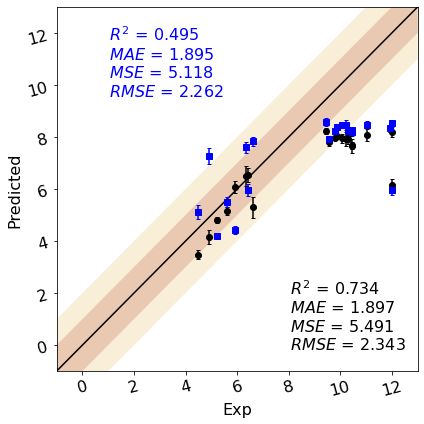

<Figure size 432x432 with 0 Axes>

In [4]:
# NOTE: SAMPL7
expS7 = pd.read_csv("../Structures/SAMPL7/SAMPL7_pKa_experimental_values.csv", index_col=False)
stdGP7 = pd.read_csv("../predictions/RandomForestSAMPL7_without_filter/macropKa_predictions.csv", index_col=False)
deepGP7 = pd.read_csv("../predictions/RandomForestSAMPL7/macropKa_predictions.csv", index_col=False)

expS7 = expS7.drop(columns=["Isomeric SMILES", "Assay Type"])
expS7.columns = ["Molecule ID","Exp.", "Exp. SEM"]

# NOTE:  Standard GP
df7 = macro_minimum_difference(exp=expS7, predictions=stdGP7)
ax = plot_result(df7, figsize=(6,6), shift_stats_pos=(2,-8.5), limits=[-1,13],
            ax=None, c="black", marker="o", show_stats=True)

# NOTE:  deep GP
df7 = macro_minimum_difference(exp=expS7, predictions=deepGP7)
plot_result(df7, figsize=(6,6), shift_stats_pos=(-5,1.), limits=[-1,13],
                ax=ax, c="blue", marker="s", show_stats=True)
fig = ax.get_figure()
fig.savefig("../figures/RF_SAMPL7_results.pdf", dpi=300)

## Macroscipic $pK_{a}$ Results for Deep GP Model in SAMPL7 w/ and w/out similatiry filter

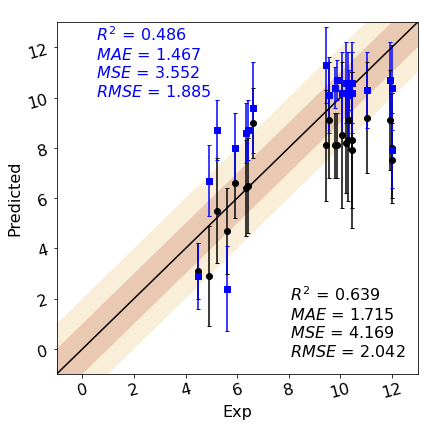

<Figure size 432x432 with 0 Axes>

In [21]:
# NOTE: SAMPL7
expS7 = pd.read_csv("../Structures/SAMPL7/SAMPL7_pKa_experimental_values.csv", index_col=False)
stdGP7 = pd.read_csv("../../SAMPL7/GPy/deepGP_without_similarity_filter/macropKa_predictions.csv", index_col=False)
deepGP7 = pd.read_csv("../predictions/SAMPL7_deepGP/macropKa_predictions.csv", index_col=False)



expS7 = expS7.drop(columns=["Isomeric SMILES", "Assay Type"])
expS7.columns = ["Molecule ID","Exp.", "Exp. SEM"]

# NOTE:  Standard GP
df7 = macro_minimum_difference(exp=expS7, predictions=stdGP7)
ax = plot_result(df7, figsize=(6,6), shift_stats_pos=(2,-9.5), limits=[-1,13],
            ax=None, c="black", marker="o", show_stats=True)

# NOTE:  deep GP
df7 = macro_minimum_difference(exp=expS7, predictions=deepGP7)
plot_result(df7, figsize=(6,6), shift_stats_pos=(-5.5,-1.25), limits=[-1,13],
                ax=ax, c="blue", marker="s", show_stats=True)
fig = ax.get_figure()
fig.savefig("../figures/SAMPL7_results_without_similarity.pdf", dpi=300)